In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from glob import glob
import pandas as pd
from copy import deepcopy
from hydra import initialize, compose
import itertools
from matplotlib.ticker import MaxNLocator
from pprint import pprint
from astropy.table import Table

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util
from mejiro.plots import plot_util

In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
# debugging = False
total = True

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

print(f'pipeline_dir: {pipeline_dir}')

pipeline_dir: /data/bwedig/mejiro/pipeline


In [3]:
# combine CSVs from each run into one CSV
data_dir = os.path.join(pipeline_dir, '00')

rebuild = False

detectable_csv = os.path.join(data_dir, 'detectable_pop.csv')
if rebuild:
    util.delete_if_exists(detectable_csv)
    detectable_df = util.combine_all_csvs(data_dir, 'detectable', detectable_csv)
else: 
    detectable_df = pd.read_csv(detectable_csv)

if total:
    total_csv = os.path.join(data_dir, 'total_pop.csv')
    if rebuild:
        util.delete_if_exists(total_csv)
        total_df = util.combine_all_csvs(data_dir, 'total', total_csv)
    else:
        total_df = pd.read_csv(total_csv)

In [4]:
# total_df.columns
# hist = total_df.hist(grid=False, figsize=(20, 20))

# detectable_df.columns
# hist = detectable_df.hist(grid=False, figsize=(20, 20))

# slacs_df.columns
# hist = slacs_df.hist(grid=False, figsize=(20, 20))
# plt.savefig(os.path.join(figure_dir, 'slacs_hist.png'))

In [5]:
table_dir = os.path.join(repo_dir, 'paper', 'tables')

slacs4_df = pd.read_csv(os.path.join(table_dir, 'Bolton2008_Table4.csv'))
slacs5_df = pd.read_csv(os.path.join(table_dir, 'Bolton2008_Table5.csv'))
bells1_df = pd.read_csv(os.path.join(table_dir, 'Shu2016a_table1.csv'))
bells2_df = pd.read_csv(os.path.join(table_dir, 'Shu2016a_table2.csv'))
sonnenfeld2_df = pd.read_csv(os.path.join(table_dir, 'Sonnenfeld2013b_table2.csv'))

from astropy.io import fits
with fits.open(os.path.join(table_dir, 'Sonnenfeld2013a_table6.fit')) as hdul:
    sonnenfeld6_data = Table(hdul[1].data)
    sonnenfeld6_df = sonnenfeld6_data.to_pandas()

In [6]:
survey_params = util.hydra_to_dict(config.survey)
# pprint(survey_params)

source_cut_band = survey_params['source_cut_band']
deflector_cut_band = survey_params['deflector_cut_band']
snr_threshold = survey_params['snr_threshold']

# OVERRIDES
# source_cut_band = 'F129'
# deflector_cut_band = 'F129'
# snr_threshold = 20

select histograms to show

In [7]:
# detectable lenses
velocity_dispersions = detectable_df.loc[:,'velodisp']
masses = detectable_df.loc[:,'massstel'] * 1e12
source_redshifts = detectable_df.loc[:,'redssour']
lens_redshifts = detectable_df.loc[:,'redslens']
einstein_radii = detectable_df.loc[:,'angleins']
num_images = detectable_df.loc[:,'numbimag']
source_magnitudes = detectable_df.loc[:,f'magtsour{source_cut_band}']
lens_magnitudes = detectable_df.loc[:,f'magtlens{deflector_cut_band}']

# total lenses
if total:
    total_velocity_dispersions = total_df.loc[:,'velodisp']
    total_masses = total_df.loc[:,'massstel'] * 1e12
    total_source_redshifts = total_df.loc[:,'redssour']
    total_lens_redshifts = total_df.loc[:,'redslens']
    total_einstein_radii = total_df.loc[:,'angleins']
    total_num_images = total_df.loc[:,'numbimag']
    total_source_magnitudes = total_df.loc[:,f'magtsour{source_cut_band}']
    total_lens_magnitudes = total_df.loc[:,f'magtlens{deflector_cut_band}']

# SLACS
slacs_velocity_dispersions = slacs4_df.loc[:,'sigma']
slacs_source_redshifts = slacs4_df.loc[:,'zBG']
slacs_lens_redshifts = slacs4_df.loc[:,'zFG']
slacs_einstein_radii = slacs5_df.loc[:,'bSIE']

# BELLS
bells_velocity_dispersions = bells1_df.loc[:,'sigma_BOSS']
bells_source_redshifts = bells1_df.loc[:,'z_S']
bells_lens_redshifts = bells1_df.loc[:,'z_L']
bells_einstein_radii = bells2_df.loc[:,'b_SIE']

# SL2S
sl2s_velocity_dispersions = sonnenfeld2_df.loc[:,'sigma']  # .dropna()
sl2s_source_redshifts = sonnenfeld2_df.loc[:,'z_s']  # .dropna()
sl2s_lens_redshifts = sonnenfeld2_df.loc[:,'z_d']  # .dropna()
sl2s_einstein_radii = sonnenfeld6_df.loc[:,'Reff']

# total HST
hst_velocity_dispersions = slacs_velocity_dispersions.to_list() + bells_velocity_dispersions.to_list() + sl2s_velocity_dispersions.to_list()
hst_source_redshifts = slacs_source_redshifts.to_list() + bells_source_redshifts.to_list() + sl2s_source_redshifts.to_list()
hst_lens_redshifts = slacs_lens_redshifts.to_list() + bells_lens_redshifts.to_list() + sl2s_lens_redshifts.to_list()
hst_einstein_radii = slacs_einstein_radii.to_list() + bells_einstein_radii.to_list() + sl2s_einstein_radii.to_list()

# remove unreliable velocity dispersion 850 from BELLS GAllERY (see note in Table 1 of Shu2016b https://ui.adsabs.harvard.edu/abs/2016ApJ...833..264S/abstract)
bells_velocity_dispersions = bells_velocity_dispersions[bells_velocity_dispersions != 850]

normalize number of images

In [8]:
num_2 = len(num_images[num_images == 2])
num_3 = len(num_images[num_images == 3])
num_4 = len(num_images[num_images == 4])
total = len(num_images)

normalized_num_2 = num_2 / total
normalized_num_3 = num_3 / total
normalized_num_4 = num_4 / total

get SNRs

In [9]:
snr_files = glob(f'{data_dir}/snr_list_*.npy')
snr_list = list(itertools.chain.from_iterable([np.load(f) for f in snr_files]))

In [10]:
# largest Einstein radius
max_einstein_radius = max(einstein_radii)
print(f'Maximum Einstein radius: {max_einstein_radius}')

Maximum Einstein radius: 3.1072510852051045


In [11]:
count_lens_redshifts_ge_1 = (lens_redshifts >= 1).sum()
print(f'Number of total lens redshifts >= 1: {count_lens_redshifts_ge_1}')
print(f'In total HLWAS, {round(count_lens_redshifts_ge_1 * (1700 / 270))}')

Number of total lens redshifts >= 1: 1128
In total HLWAS, 7102


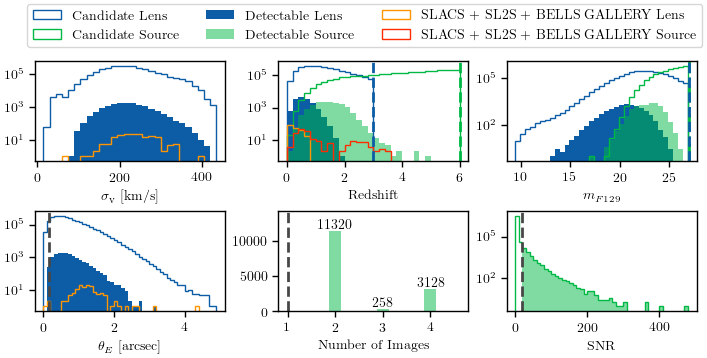

In [12]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(7, 3), constrained_layout=True)

# colors
color_lens = 'C0'
color_source = 'C1'
color_slacs_lens = 'C2'
color_slacs_source = 'C3'
color_else = 'C5'

alpha_detectable_lens = 1.
alpha_detectable_source = 0.5
alpha_hst_lens = 1
alpha_hst_source = 1

binwidth = 15
bins = np.arange(min(total_velocity_dispersions), max(total_velocity_dispersions) + binwidth, binwidth)
if total: ax[0][0].hist(total_velocity_dispersions, label='Total', histtype='step', color=color_lens, bins=bins)
ax[0][0].hist(velocity_dispersions, label='Detectable', alpha=alpha_detectable_lens, color=color_lens, bins=bins)
ax[0][0].hist(hst_velocity_dispersions, label='SLACS', alpha=alpha_hst_lens, color=color_slacs_lens, bins=bins, histtype='step')
ax[0][0].set_xlabel(r'$\sigma_\textrm{v}$ [km/s]')
ax[0][0].set_yscale('log')

binwidth = 0.2
bins = np.arange(0, max(total_source_redshifts) + binwidth, binwidth)
if total: ax[0][1].hist(total_lens_redshifts, label='Candidate Lens', histtype='step', color=color_lens, bins=bins)  # , align='left'
if total: ax[0][1].hist(total_source_redshifts, label='Candidate Source', histtype='step', color=color_source, bins=bins)  # , align='left'
ax[0][1].hist(lens_redshifts, label='Detectable Lens', alpha=alpha_detectable_lens, color=color_lens, bins=bins)
ax[0][1].hist(source_redshifts, label='Detectable Source', alpha=alpha_detectable_source, color=color_source, bins=bins)
ax[0][1].hist(hst_lens_redshifts, label='SLACS + SL2S + BELLS GALLERY Lens', alpha=alpha_hst_lens, color=color_slacs_lens, bins=bins, histtype='step')
ax[0][1].hist(hst_source_redshifts, label='SLACS + SL2S + BELLS GALLERY Source', alpha=alpha_hst_source, color=color_slacs_source, bins=bins, histtype='step')
ax[0][1].axvline(survey_params['source_z_max'], color=color_source, linestyle='--')
ax[0][1].axvline(survey_params['deflector_z_max'], color=color_lens, linestyle='--')
ax[0][1].set_yscale('log')
ax[0][1].set_xlabel('Redshift')

# x1, x2, y1, y2 = 0, 2.25, 0.5, 1e3
# zoom_axes = ax[0][1].inset_axes(bounds=[0.475,0.3,0.425,0.45], xlim=(x1, x2), ylim=(y1, y2))
# zoom_axes.hist(source_redshifts, label='Detectable Source', alpha=0.75)
# zoom_axes.hist(lens_redshifts, label='Detectable Lens', alpha=0.75)
# zoom_axes.hist(slacs_source_redshifts, label='SLACS Source', alpha=0.5, color='y')
# zoom_axes.hist(slacs_lens_redshifts, label='SLACS Lens', alpha=0.5, color='r')
# zoom_axes.set_yscale('log')
# zoom_axes.tick_params(axis='y', which='both', left=False, labelleft=False)
# zoom_axes.set_xticks([0, 1.5])
# ax[0][1].indicate_inset_zoom(zoom_axes, edgecolor="black")

binwidth = 0.5
bins = np.arange(min(total_lens_magnitudes), max(total_lens_magnitudes) + (binwidth / 2), binwidth)
if total: ax[0][2].hist(total_lens_magnitudes, histtype='step', color=color_lens, bins=bins)
if total: ax[0][2].hist(total_source_magnitudes, histtype='step', color=color_source, bins=bins)
ax[0][2].hist(lens_magnitudes, alpha=alpha_detectable_lens, color=color_lens, bins=bins)
ax[0][2].hist(source_magnitudes, alpha=alpha_detectable_source, color=color_source, bins=bins)
ax[0][2].axvline(survey_params['source_cut_band_max'], linestyle='-.', color=color_source)
ax[0][2].axvline(survey_params['deflector_cut_band_max'], linestyle='--', color=color_lens)
ax[0][2].set_yscale('log')
assert source_cut_band == deflector_cut_band, 'Source and deflector cut bands must be the same for the label on this plot to be true'
ax[0][2].set_xlabel(r'$m_{%s}$' % source_cut_band)
# ax[0][2].invert_xaxis()

binwidth = 0.1
bins = np.arange(0, max(total_einstein_radii) + binwidth, binwidth)
if total: ax[1][0].hist(total_einstein_radii, histtype='step', color=color_lens, bins=bins)
ax[1][0].hist(einstein_radii, alpha=alpha_detectable_lens, color=color_lens, bins=bins)
ax[1][0].hist(hst_einstein_radii, alpha=alpha_hst_lens, color=color_slacs_lens, bins=bins, histtype='step')
ax[1][0].axvline(survey_params['min_image_separation'] / 2, linestyle='--', color=color_else)
ax[1][0].set_xlabel(r'$\theta_E$ [arcsec]')
ax[1][0].set_yscale('log')
# ax[1][0].set_xlim([0,2])

labels, counts = np.unique(num_images, return_counts=True)
bars = ax[1][1].bar(labels, counts, label='Detectable', alpha=alpha_detectable_source, color=color_source, width=0.25)
# counts, edges, bars = ax[1][1].hist(num_images, label='Detectable', alpha=alpha_detectable_source, color=color_source)
# bar_2 = ax[1][1].bar(2, normalized_num_2, label='Detectable', alpha=0.5, color=color_source, width=0.25)
# bar_3 = ax[1][1].bar(3, normalized_num_3, alpha=0.5, color=color_source, width=0.25)
# bar_4 = ax[1][1].bar(4, normalized_num_4, alpha=0.5, color=color_source, width=0.25)
ax[1][1].axvline(1, linestyle='--', color=color_else)
ax[1][1].set_xlabel('Number of Images')
labels = [int(v) if v > 0 else '' for v in counts]
ax[1][1].bar_label(bars, labels=labels, label_type='edge')
# ax[1][1].bar_label(bar_2, labels=[f'{normalized_num_2:.2f}'], label_type='edge')
# ax[1][1].bar_label(bar_3, labels=[f'{normalized_num_3:.2f}'], label_type='edge')
# ax[1][1].bar_label(bar_4, labels=[f'{normalized_num_4:.2f}'], label_type='edge')
ax[1][1].set_xlim([0.8, 4.8])  # make some horizontal space for the bar labels
ax[1][1].set_ylim([0, 1.25 * counts[0]])  # make some vertical space for the bar labels
ax[1][1].xaxis.set_major_locator(MaxNLocator(integer=True))
# ax[1][0].ticklabel_format(axis='y', style='plain', scilimits=(0,0))

bin_width = snr_threshold / 2
snr_list = [snr for snr in snr_list]
bins = np.arange(min(snr_list), max(snr_list) + bin_width, bin_width)
_, bins, _ = ax[1][2].hist(snr_list, bins=bins, label='Total', histtype='step', color=color_source)
detectable_snrs = [i for i in snr_list if i > snr_threshold]
ax[1][2].hist(detectable_snrs, bins=bins[1:], label='Detectable', alpha=alpha_detectable_source, color=color_source)
ax[1][2].axvline(x=snr_threshold, linestyle='--', color=color_else)
ax[1][2].set_xlabel('SNR')
ax[1][2].set_yscale('log')

# create legend using colors and labels from the redshift panel
handles, labels = ax[0][1].get_legend_handles_labels()
f.legend(handles, labels, loc='upper center', ncols=3, bbox_to_anchor=(0.52, 1.2))

plt.savefig(os.path.join(figure_dir, 'skypy_pop_hist.png'))
plt.show()

Text(0.5, 1.0, '0.1515423779980638')

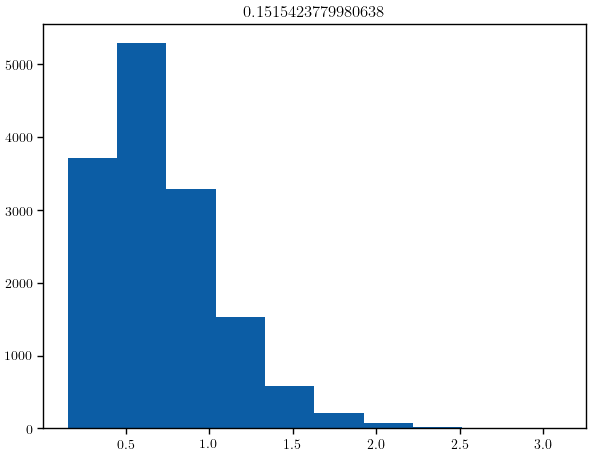

In [15]:
plt.hist(einstein_radii)
plt.title(np.min(einstein_radii))

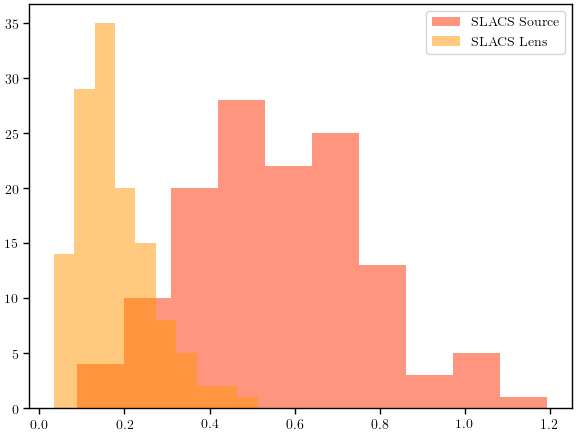

In [16]:
_, ax = plt.subplots()
ax.hist(slacs_source_redshifts, label='SLACS Source', alpha=0.5, color=color_slacs_source)
ax.hist(slacs_lens_redshifts, label='SLACS Lens', alpha=0.5, color=color_slacs_lens)
ax.legend()
plt.show()

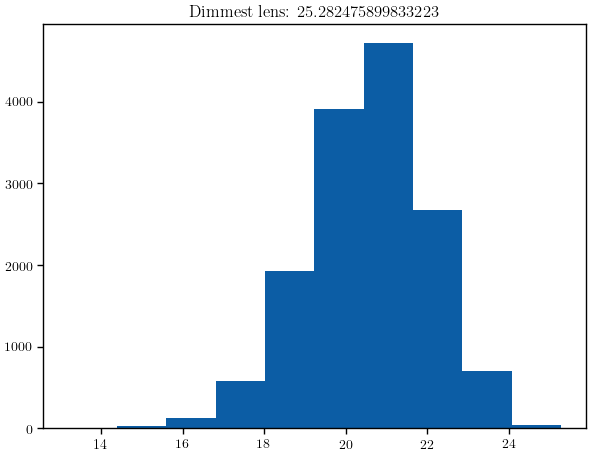

In [17]:
plt.hist(lens_magnitudes)
plt.title(f'Dimmest lens: {np.max(lens_magnitudes)}')
plt.show()

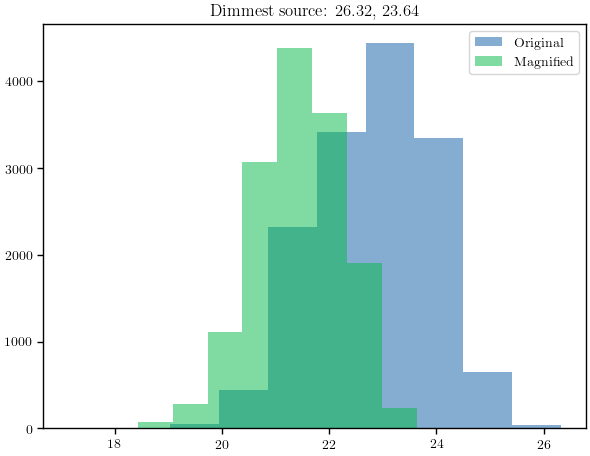

In [18]:
magnified_source = detectable_df.loc[:,f'magtsourMagnified{source_cut_band}']

plt.hist(source_magnitudes, label='Original', alpha=0.5)
plt.hist(magnified_source, label='Magnified', alpha=0.5)
plt.title(f'Dimmest source: {np.max(source_magnitudes):.2f}, {np.max(magnified_source):.2f}')
plt.legend()
plt.show()

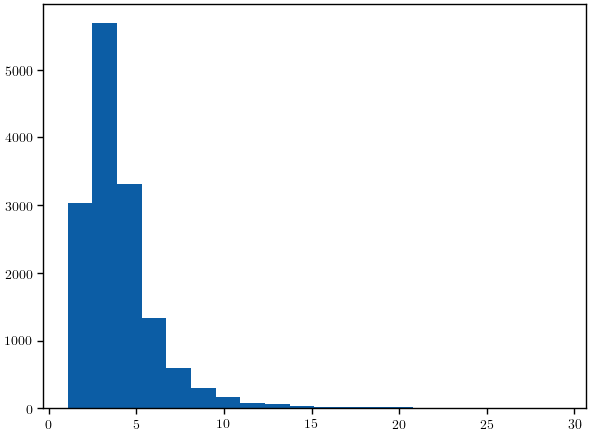

Percentage of detectable lenses with magnification > 3: 73.45%


In [19]:
magnification = detectable_df.loc[:,'magnsour']
plt.hist(magnification, bins=20)
plt.show()

magn_gtr_3 = detectable_df.loc[magnification > 3, :]
print(f'Percentage of detectable lenses with magnification > 3: {len(magn_gtr_3) / len(detectable_df) * 100:.2f}%')

In [20]:
einstein_radii.sort_values(ascending=True).head(10)

9290     0.151542
732      0.151706
13098    0.151811
4704     0.152823
13538    0.153346
1726     0.154212
9935     0.154717
11235    0.154953
7806     0.154991
13333    0.155083
Name: angleins, dtype: float64

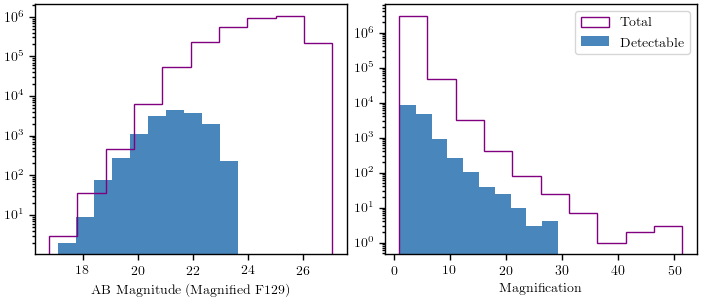

In [21]:
total_magnified_source = total_df.loc[:,f'magtsourMagnified{source_cut_band}']  # magtsourMagnifiedF129
magnified_source = detectable_df.loc[:,f'magtsourMagnified{source_cut_band}']

total_magnification = total_df.loc[:,'magnsour']  
magnification = detectable_df.loc[:,'magnsour']

f, ax = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)
ax[0].hist(total_magnified_source, label='Total', histtype='step', color='purple')
ax[0].hist(magnified_source, label='Detectable', alpha=0.75)
ax[0].set_xlabel(f'AB Magnitude (Magnified {source_cut_band})')
ax[0].set_yscale('log')
ax[1].hist(total_magnification, label='Total', histtype='step', color='purple')
ax[1].hist(magnification, label='Detectable', alpha=0.75)
ax[1].set_xlabel('Magnification')
ax[1].set_yscale('log')
plt.legend()
plt.show()

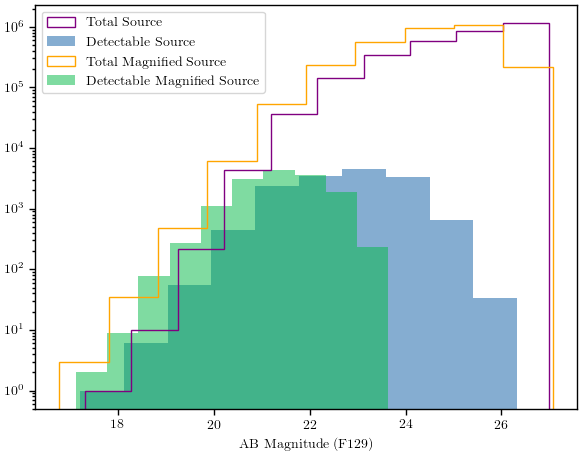

In [22]:
plt.hist(total_source_magnitudes, label='Total Source', histtype='step', color='purple')
plt.hist(source_magnitudes, label='Detectable Source', alpha=0.5)
plt.hist(total_magnified_source, label='Total Magnified Source', histtype='step', color='orange')
plt.hist(magnified_source, label='Detectable Magnified Source', alpha=0.5)
plt.xlabel(f'AB Magnitude ({source_cut_band})')
plt.yscale('log')
plt.legend()
plt.show()

In [23]:
source_mags_f087 = detectable_df.loc[:,f'magtsourF087']
source_mags_f106 = detectable_df.loc[:,f'magtsourF106']
source_mags_f129 = detectable_df.loc[:,f'magtsourF129']
source_mags_f158 = detectable_df.loc[:,f'magtsourF158']
source_mags_f184 = detectable_df.loc[:,f'magtsourF184']

lens_mags_f087 = detectable_df.loc[:,f'magtlensF087']
lens_mags_f106 = detectable_df.loc[:,f'magtlensF106']
lens_mags_f129 = detectable_df.loc[:,f'magtlensF129']
lens_mags_f158 = detectable_df.loc[:,f'magtlensF158']
lens_mags_f184 = detectable_df.loc[:,f'magtlensF184']

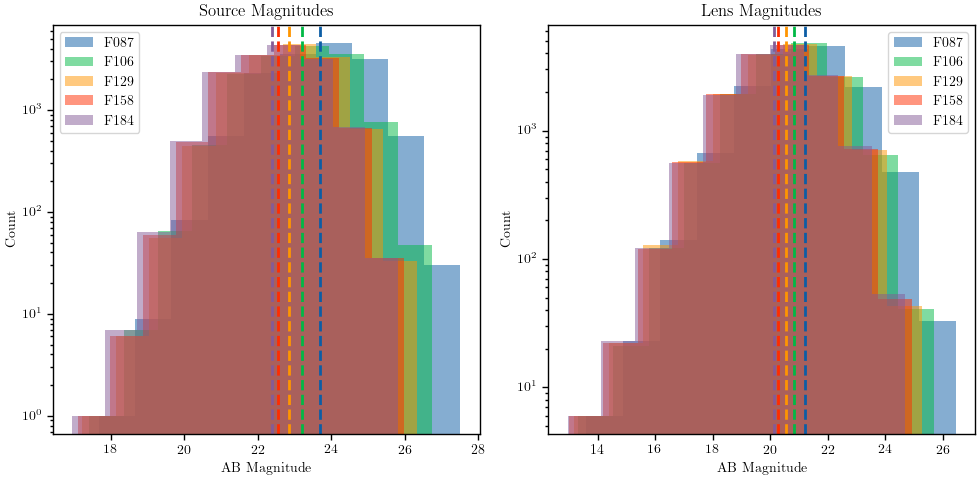

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Source Magnitudes
axs[0].hist(source_mags_f087, label='F087', alpha=0.5, color='C0')
axs[0].hist(source_mags_f106, label='F106', alpha=0.5, color='C1')
axs[0].hist(source_mags_f129, label='F129', alpha=0.5, color='C2')
axs[0].hist(source_mags_f158, label='F158', alpha=0.5, color='C3')
axs[0].hist(source_mags_f184, label='F184', alpha=0.5, color='C4')

axs[0].axvline(np.mean(source_mags_f087), color='C0', linestyle='--')
axs[0].axvline(np.mean(source_mags_f106), color='C1', linestyle='--')
axs[0].axvline(np.mean(source_mags_f129), color='C2', linestyle='--')
axs[0].axvline(np.mean(source_mags_f158), color='C3', linestyle='--')
axs[0].axvline(np.mean(source_mags_f184), color='C4', linestyle='--')

axs[0].set_xlabel('AB Magnitude')
axs[0].set_ylabel('Count')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_title('Source Magnitudes')

# Lens Magnitudes
axs[1].hist(lens_mags_f087, label='F087', alpha=0.5, color='C0')
axs[1].hist(lens_mags_f106, label='F106', alpha=0.5, color='C1')
axs[1].hist(lens_mags_f129, label='F129', alpha=0.5, color='C2')
axs[1].hist(lens_mags_f158, label='F158', alpha=0.5, color='C3')
axs[1].hist(lens_mags_f184, label='F184', alpha=0.5, color='C4')

axs[1].axvline(np.mean(lens_mags_f087), color='C0', linestyle='--')
axs[1].axvline(np.mean(lens_mags_f106), color='C1', linestyle='--')
axs[1].axvline(np.mean(lens_mags_f129), color='C2', linestyle='--')
axs[1].axvline(np.mean(lens_mags_f158), color='C3', linestyle='--')
axs[1].axvline(np.mean(lens_mags_f184), color='C4', linestyle='--')

axs[1].set_xlabel('AB Magnitude')
axs[1].set_ylabel('Count')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_title('Lens Magnitudes')

plt.tight_layout()
# plt.savefig(os.path.join(figure_dir, 'source_lens_mags.png'))
plt.show()